## Feature engineering

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Interaction Features
def create_interaction_features(df):
    """Create interaction features from the student performance dataset"""
    
    # Copy the dataframe to avoid modifying the original
    df_new = df.copy()
    
    # Parent-Study interaction: How parental support might amplify study effectiveness
    df_new['ParentStudyInteraction'] = df_new['ParentalSupport'] * df_new['StudyTimeWeekly']
    
    # Extracurricular intensity: Sum of all activity participations
    df_new['ExtracurricularIntensity'] = df_new['Sports'] + df_new['Music'] + df_new['Volunteering']
    
    # Academic involvement intensity: Combines study time and tutoring
    df_new['AcademicInvolvement'] = df_new['StudyTimeWeekly'] * (1 + 0.5 * df_new['Tutoring']) # Combines study time and tutoring to reflect overall academic effort, giving 50% more weight to students with tutoring
    
    return df_new

# 3. Ratio and Aggregate Features
def create_ratio_aggregate_features(df):
    """Create ratio and aggregate features from the student performance dataset"""
    
    # Copy the dataframe to avoid modifying the original
    df_new = df.copy()
    
    # Study efficiency: ratio of study time to absences (with handling for zero absences)
    df_new['StudyEfficiency'] = df_new['StudyTimeWeekly'] / (df_new['Absences'] + 1)
    
    # Academic balance: ratio of study time to extracurricular activities
    extracurricular_count = df_new[['Sports', 'Music', 'Volunteering']].sum(axis=1)
    # Adding 1 to avoid division by zero
    df_new['AcademicBalance'] = df_new['StudyTimeWeekly'] / (extracurricular_count + 1)
    
    return df_new

# Combined function to apply both feature engineering techniques
def engineer_features(df):
    """Apply both interaction and ratio/aggregate feature engineering"""
    df = create_interaction_features(df)
    df = create_ratio_aggregate_features(df)
    return df


## Random forest algorithm

In [15]:
# Apply feature engineering

df = pd.read_csv('../../Data/Student_performance_non_scaled.csv')

df_engineered = engineer_features(df)

# Define feature set and target
X = df_engineered.drop('GradeClass', axis=1) 
y = df_engineered['GradeClass']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

rf = RandomForestClassifier(random_state=42)

# Hyperparameter grid (In order tO better the accuracy of the model)
param_grid = {
    'n_estimators': [100, 200, 300], # Number of trees in the forest; no more than 300 as it would result in too much computation
    'max_depth': [10, 20] # Maximum depth of each tree; 10, 20 to limit complexity to prevent overfitting
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(
    rf, # Base model with fixed random seed
    param_grid=param_grid, # Hyperparameter grid to search over
    cv=15,
    scoring='accuracy', # Use accuracy as the metric to optimize
    n_jobs=-1 # Use all available CPU cores to increase the speed of execution of the algorithm
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_


# Make predictions
y_pred = best_model.predict(X_test)

## Analyzing the model

Best parameters: {'max_depth': 10, 'n_estimators': 200}

Accuracy: 0.7157190635451505

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.22      0.32        27
         1.0       0.57      0.52      0.55        67
         2.0       0.51      0.58      0.55        98
         3.0       0.50      0.56      0.53       103
         4.0       0.91      0.90      0.90       303

    accuracy                           0.72       598
   macro avg       0.62      0.56      0.57       598
weighted avg       0.72      0.72      0.71       598



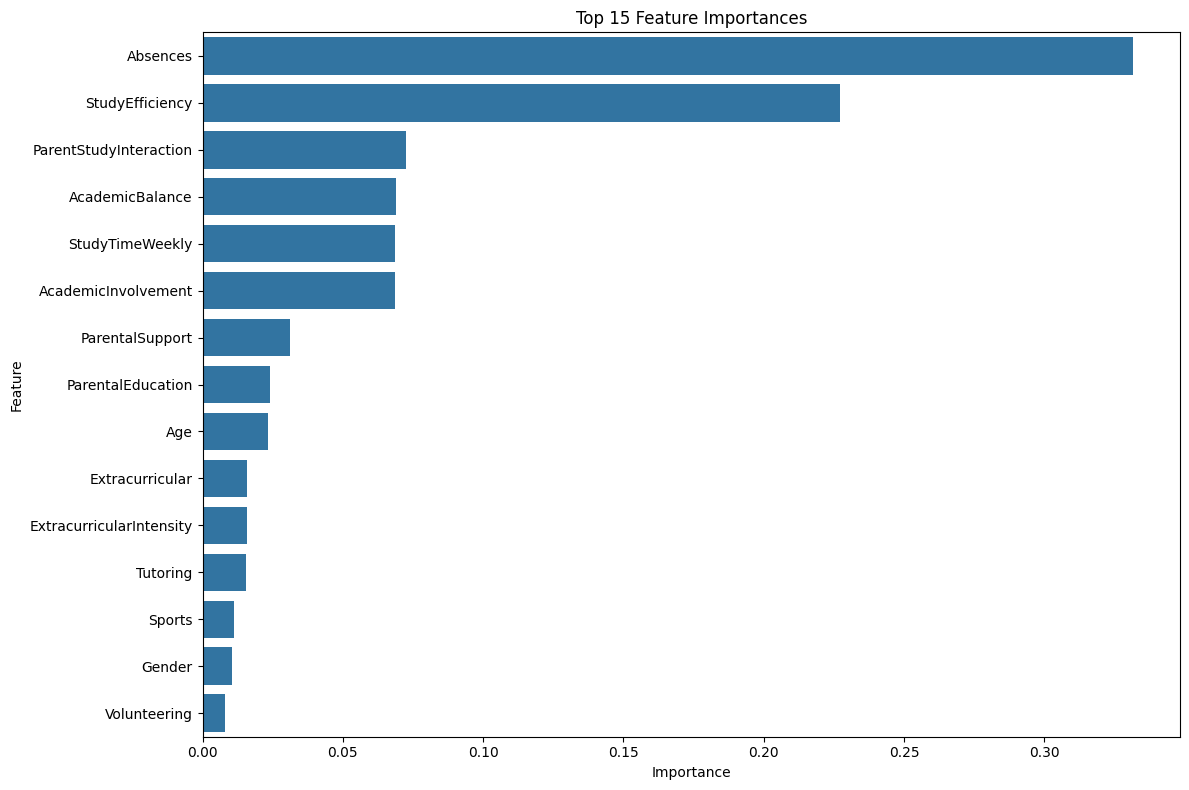

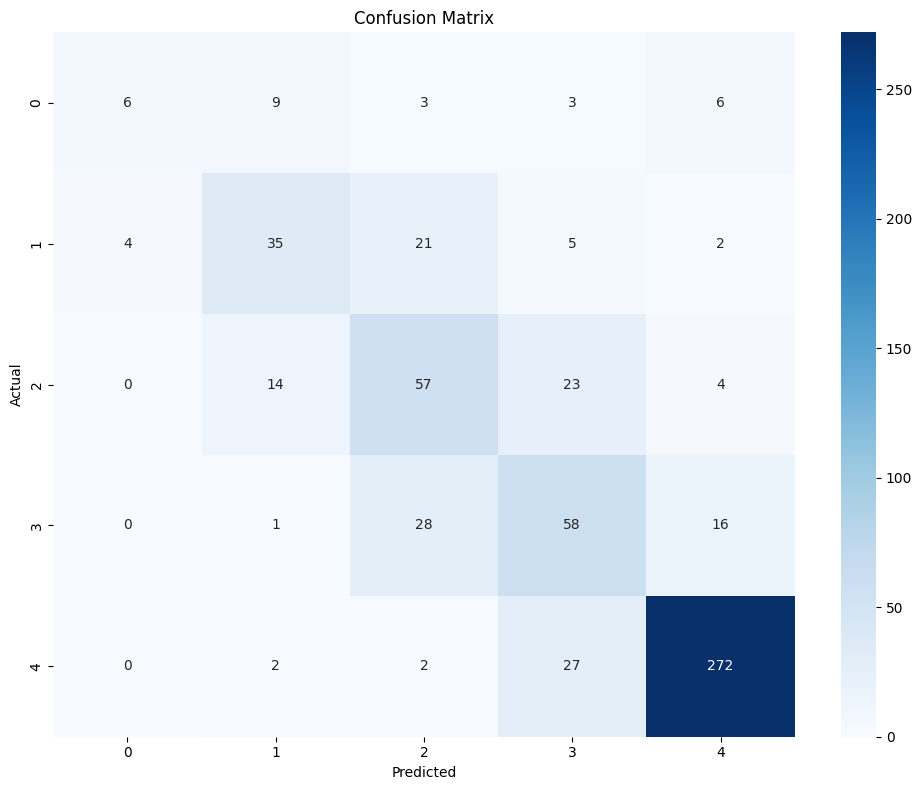

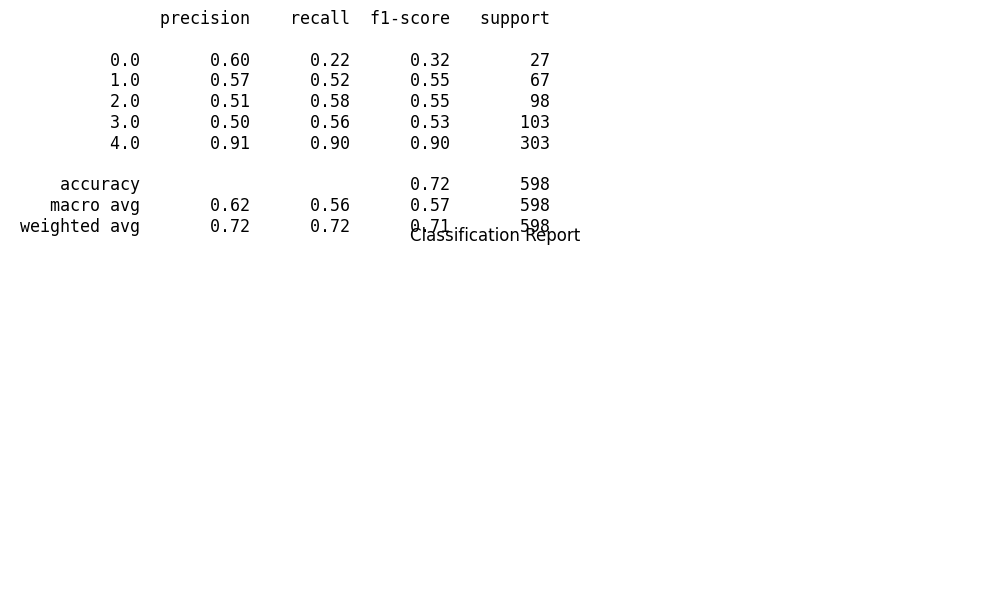

In [16]:
#Evaluate the model Parameters (the hyperparameters that were applied)

print("Best parameters:", grid_search.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance analysis
feature_importances = best_model.feature_importances_
feature_names = X.columns

# Create DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.savefig('../../artifacts/plots/RF_feature_importance.png')


# Confusion matrix plot
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../../artifacts/plots/RF_confusion_matrix.png')


# Classification report as PNG
plt.figure(figsize=(10, 6))
plt.text(0.01, 0.99, classification_report(y_test, y_pred), {'fontsize': 12}, fontfamily='monospace')
plt.axis('off')
plt.title('Classification Report')
plt.tight_layout()
plt.savefig('../../artifacts/plots/RF_classification_report.png', bbox_inches='tight')


### Save the artifacts

In [17]:
import pickle

# Save the model results
results = {
    'accuracy': accuracy_score(y_test, y_pred),
    'best_params': grid_search.best_params_,
    'feature_importance': importance_df
}

# Export results to CSV
importance_df.to_csv('../../artifacts/plots/RF_feature_importance.csv', index=False)

# Export predictions to CSV
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
predictions_df.to_csv('../../artifacts/predictions/RF_predictions.csv', index=False)

# Export the model as .pkl
with open('../../artifacts/models/RF_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Explanation of the results

## Best parameters explanation:
  * `max_depth: 10`: Limits tree depth of each tree to 10 branches to prevent overfitting trees.
   * `n_estimators: 200`: The number of trees, although this increases the execution time of the model, it does allow for a more accurate prediction.

## Accuracy explanation:
 * Overall accuracy is **71.57%**, however the accuracy is further explored in the classification report.

## Classification report explanation:
   The classification report provides precision, recall, f1-score, and support for each class. 

   * **Class 0.0**:
     * **Explanation:**: The model struggles to identify class 0.0 instances (indicated by the recall value of 22% and the f1-score of 32%), likely due to the low amount of data points that are present to train and test the model on (only 27 data points are available as indicated by the support). This is not a huge issue as this class is the top performance students thus a high accuracy here is not the biggest concern.

   * **Class 1.0, 2.0 AND 3.0**:
     * **Explanation:**: The model preforms relatively the same for these classes, with high recall (**52% for class 1.0**, **0.58 for class 2.0** and **0.56 for class 3.0**) suggesting it’s not reliable for accurate predictions, this is also indicated by the **f1 score of 55% in class 1.0, 55% in class 2.0 and 53% in class 3.0**.

   * **Class 4.0**:
     * **Explanation:**: The model preforms the best here, likely due to the large number of samples. This is also the most important class to be accurate in as this class indicates the problem students. Having a high accuracy here is very beneficial. The model has an accuracy of **90% as indicated by the f1 and recall value of 0.90**

## The Top 10 most important features 
This shows what features has the greatest effect on the target variable (Grade class).

